In [6]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from typing import List

import time 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pytorch_lightning as pl

from torch import Tensor, einsum
from einops import parse_shape, rearrange, repeat

np.set_printoptions(precision=5, edgeitems=20, linewidth=250)
torch.set_printoptions(precision=5, sci_mode=False, edgeitems=20, linewidth=250)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_parameters_all(model: nn.Module):
    return sum(p.numel() for p in model.parameters())

def exists(value):
    return value is not None 

TOUGHTS:
* Error doesn't seem to explode, with enough training to gets better.
* Small number of channels seem to work well
* Strided convolutions (K=S) might be necessary to aggregate patterns.
* Decoder is more powerful since it must reconstruct.

TODO:
* Find good layer config to generate from latent. 


In [544]:
W = 128
K = 2
S = 2
P = 0
size = ((W-K+2*P)/S)+1
print(3*3*K*K*2*100)
print(size)

x = torch.rand(1, 3, 128, 128)

enc = nn.Conv2d(
    in_channels = 3,
    out_channels = 3,
    kernel_size = K,
    stride = S,
    padding = P
)

print(enc(enc(enc(enc(enc(enc(enc(x))))))).shape)

dec = nn.ConvTranspose2d(
    in_channels = 3,
    out_channels = 3,
    kernel_size = K,
    stride = S,
    padding = P
)

print(dec(enc(x)).shape)

7200
64.0
torch.Size([1, 3, 1, 1])
torch.Size([1, 3, 128, 128])


In [743]:
import torch.nn.functional as F
import torch.optim as optim

class Sin(nn.Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return torch.sin(1.0 * x)

class Block(nn.Module):
    
    def __init__(
        self,
        in_channels: int, 
        out_channels: int
    ):
        super().__init__() 
        
        self.encode = nn.Sequential(
            nn.Conv2d(
                in_channels = in_channels,
                out_channels = out_channels,
                kernel_size = 2,
                stride = 2,
                padding = 0 
            ),
            Sin(),
        )
        
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels = out_channels,
                out_channels = in_channels,
                kernel_size = 2,
                stride = 2,
                padding = 0 
            ),
            Sin(),
            nn.Conv2d(
                in_channels=in_channels, 
                out_channels=in_channels, 
                kernel_size=3,
                padding=1,
            ),
            Sin(),
            nn.Conv2d(
                in_channels=in_channels, 
                out_channels=in_channels, 
                kernel_size=1
            )
        )
        
# we reduce res by half only of 3 channel images, with a lot of filters s.t. we can reconstruct
# output is half res and a lot of channels, then we reduce the channels to 3 and repeat

class Model(pl.LightningModule):
    def __init__(
        self,
        lr: float
    ):
        super().__init__()
        self.channels = 3 
        self.num_layers = 7
        chn_list = [3, 8, 16, 32, 64, 128, 256, 512]
        channels = list(zip(chn_list[:-1], chn_list[1:]))
        #print(channels)
        
        self.blocks = nn.ModuleList([
            Block(channels[i][0], channels[i][1])
            for i in range(self.num_layers)
        ])
        self.lr = lr 
        
    def requires_grad(self, requires_grad):
        for param in self.parameters():
            param.requires_grad = requires_grad
        
    def forward(self, x, optimizers=None):
        update = exists(optimizers)
        xs, xs_recon = [x], []
        
        
        for i in range(self.num_layers):
            x_curr = xs[-1]
            x_next = self.blocks[i].encode(x_curr)
            x_recon = self.blocks[i].decode(x_next)  
            
            # Forward optimization 
            if update:
                # Optimize input
                loss = F.mse_loss(x_curr, x_recon)
                optimizer = optimizers[i]
                optimizer.zero_grad() 
                self.manual_backward(loss)
                self.log(f"loss_f{i}", loss, on_step=True, prog_bar=True)
                optimizer.step() 
                # Detach output 
                x_next = x_next.detach() 
                x_recon = x_recon.detach()
                
            xs += [x_next]
            xs_recon += [x_recon]
            
        for i in reversed(range(self.num_layers-1)):
            x_curr = xs_recon[i+1]
            x_prev = self.blocks[i].decode(x_curr)
            x_target = xs[i]
            xs_recon_back = []
            
            # Backward optimization
            if update:
                loss = F.mse_loss(x_target, x_prev)
                optimizer = optimizers[i]
                optimizer.zero_grad() 
                self.manual_backward(loss)
                self.log(f"loss_b{i}", loss, on_step=True, prog_bar=True)
                optimizer.step() 
                
        return xs, xs_recon  

    def configure_optimizers(self):
        optimizers = []
        for i in range(self.num_layers):
            params = self.blocks[i].parameters()
            optimizers += [torch.optim.Adam(params, lr=self.lr)]
        return optimizers
    
    def reattach(self, x: Tensor) -> Tensor:
        return x.detach().requires_grad_() 
    
    @property
    def automatic_optimization(self) -> bool:
        return False
     
    def training_step(self, batch, batch_idx):
        self(batch, optimizers = self.optimizers())
    
        

model = Model(lr = 0.001)

In [744]:
from brainle.datamodules.image_datamodule import ImageDatamodule 
from brainle.datamodules.transforms.to_float import ToFloat 
   
datamodule = ImageDatamodule(
    data_dir = "../data/archive.zip",
    train_val_split= [50000, 11214],
    batch_size = 4,
    num_workers = 0,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=128),
        torchvision.transforms.RandomCrop(size=[128, 128]),
        torchvision.transforms.PILToTensor(),
        ToFloat()
    ])
)

# Callbacks 
cb_progress_bar = pl.callbacks.RichProgressBar()
cb_model_summary = pl.callbacks.RichModelSummary()

In [757]:
trainer = pl.Trainer(callbacks=[cb_model_summary], max_epochs=200)
trainer.fit(model=model, datamodule=datamodule)
# 3 * 128 * 128 = 49152 -> 12 * 64 * 64 = 49152, 0.0000914

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name   ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ blocks │ ModuleList │  2.3 M │
└───┴────────┴────────────┴────────┘

Trainable params: 2.3 M                                                                      
Non-trainable params: 0                                                                      
Total params: 2.3 M                                                                          
Total estimated model params size (MB): 9

Training: 0it [00:00, ?it/s]

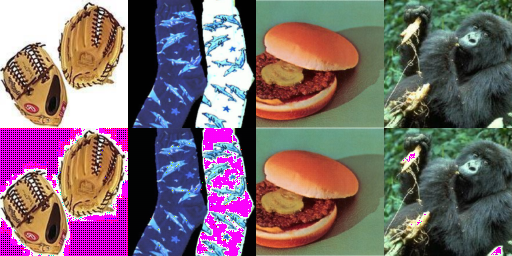

In [758]:
to_image = torchvision.transforms.ToPILImage()
#sample = next(iter(datamodule.val_dataloader()))  

grid = rearrange([sample, model(sample)[1][0]], "n b c h w -> c (n h) (b w) ")
to_image(grid)

torch.Size([4, 512, 1, 1])


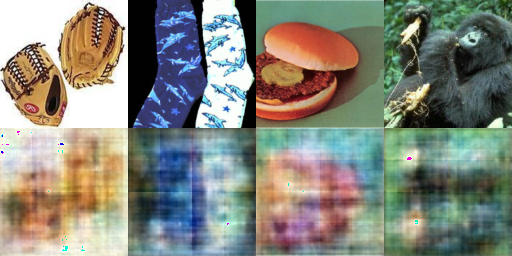

In [759]:
x_init = sample
x = x_init

layers = 7

for i in range(layers):
    x = model.blocks[i].encode(x)  
    
print(x.shape)
for i in reversed(range(layers)):
    x = model.blocks[i].decode(x)  
    
grid = rearrange([x_init, x], "n b c h w -> c (n h) (b w) ")
to_image(grid)

torch.Size([10, 512, 1, 1])


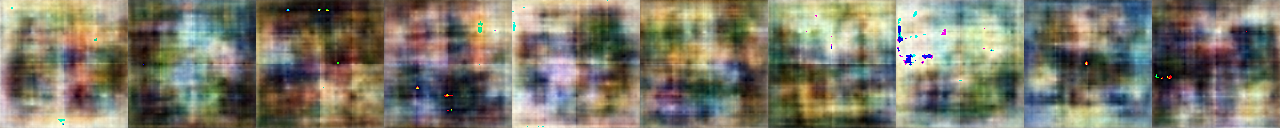

In [765]:
x = torch.randn(10, 512, 1,1) 
layers = 7

print(x.shape)
for i in reversed(range(layers)):
    x = model.blocks[i].decode(x)  
    
grid = rearrange(x, "b c h w -> c h (b w) ")
to_image(grid)

Output()

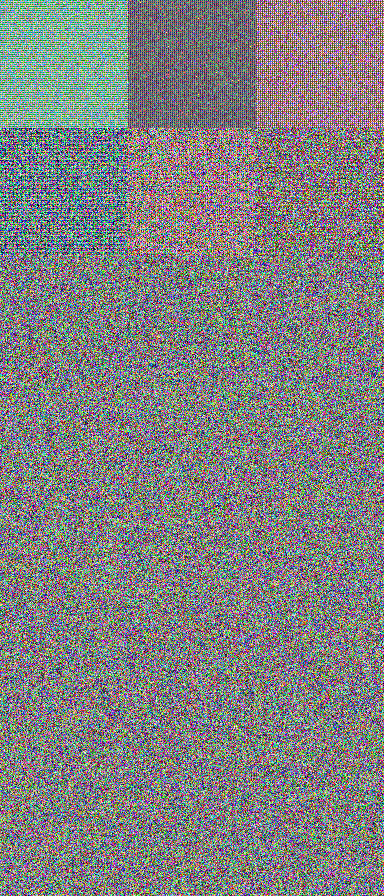

In [638]:
import cv2
from rich.progress import track
from PIL import Image

# Compute gradient of filter wrt to input 
steps = 100
num_layers = model.num_layers
num_filters = 3
images = []

sample_img = sample[0].unsqueeze(0) #
sample_rand = torch.rand((1, 3, 128, 128), requires_grad=True)#
start = sample_rand

for layer_id in track(range(num_layers)):
    for filter_id in range(num_filters):
        
        img = start.clone().detach()
        img.requires_grad = True
        model.requires_grad(False)
        optimizer = torch.optim.Adam([img], lr=0.1, weight_decay=1e-6)

        for n in range(steps): 
            optimizer.zero_grad()
            pattern = model(img)[0][layer_id+1][0, filter_id]
            loss = - pattern.mean()
            loss.backward()
            optimizer.step()    

        model.requires_grad(True)
        images.append(img[0])
    
grid = to_image(rearrange(images, '(l f) c h w -> c (l h) (f w)', l=num_layers))
grid

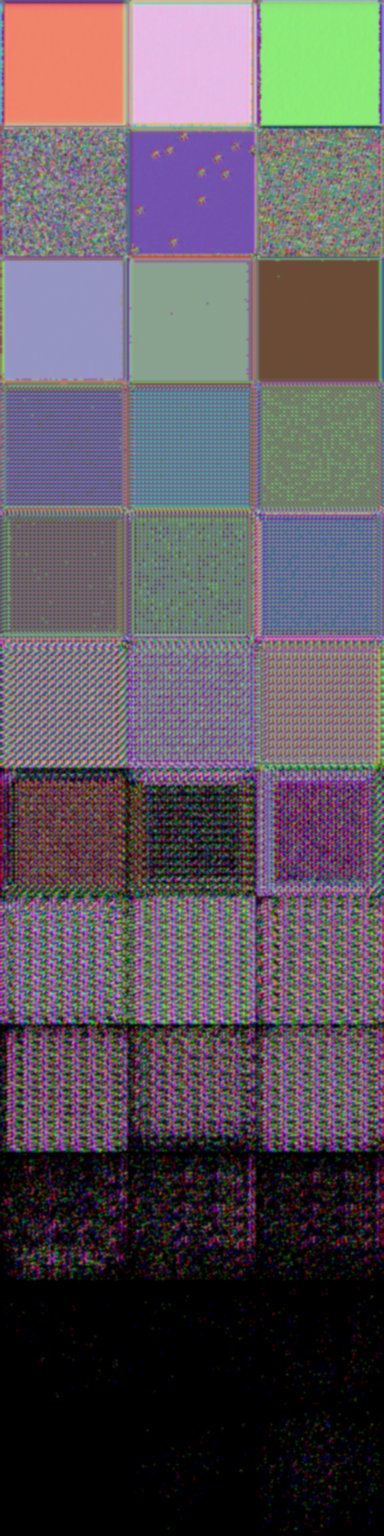

In [216]:
blur = torchvision.transforms.GaussianBlur((11,11), sigma=(1,1))
to_tensor = torchvision.transforms.ToTensor()
to_image(blur(to_tensor(grid)))